In [13]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.regdata import RegData
from funcs.reloads import Reloader
from classes.natspatpred import NatSpatPred
from classes.voxelsieve import VoxelSieve

['/home/rfpred/notebooks/clean', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home/rfpred/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode', '/home

In [9]:
NSP = NatSpatPred()
NSP.initialise(verbose=False)

In [14]:
def get_img_extremes_multi_layer(
        # self,
        X: np.ndarray,
        n: int,
        layers: list,
        weights: list = None,
        top: str = "unpred",
        start_img: int = 0,
        add_circle: bool = True,
        plot: bool = True,
        verbose: bool = True,
    ):
        """
        Returns the indices of the top or bottom n values considering multiple layers of the input array X.

        Parameters:
        X (ndarray): Input array of shape (m, n_layers).
        n (int): Number of indices to return.
        layers (List[int]): List of layer indices to consider.
        weights (List[float], optional): Weights for each layer. If None, equal weights are used.
        top (str): "unpred" for top unpredictable, "pred" for top predictable. Default is "unpred".
        start_img (int): Starting index for image selection. Default is 0.
        add_circle (bool): Whether to add a circular mask to the images. Default is True.
        plot (bool): Whether to plot the results. Default is True.
        verbose (bool): Whether to print verbose output. Default is True.

        Returns:
        ndarray: Array of shape (n,) containing the indices of the selected images.
        """
        if weights is None:
            weights = [1] * len(layers)
        
        if len(layers) != len(weights):
            raise ValueError("Number of layers must match number of weights.")

        # Combine scores from multiple layers
        combined_scores = np.zeros(X.shape[0])
        for layer, weight in zip(layers, weights):
            combined_scores += weight * X[:, layer]

        # Sort the combined scores
        sorted_indices = np.argsort(combined_scores)

        final_img = start_img + n

        # Select top or bottom n indices
        if top == "unpred":
            n_indices = sorted_indices[-final_img:-start_img if start_img != 0 else None]
            n_indices = n_indices[::-1]  # Reverse for descending order
            topbottom_str = "top unpredictable"
        else:
            n_indices = sorted_indices[start_img:final_img]
            topbottom_str = "top predictable"

        if plot:
            # Plot the value distribution
            plt.figure(figsize=(10, 6))
            plt.plot(sorted(combined_scores)[-final_img:] if top == "unpred" else sorted(combined_scores)[:final_img])
            plt.title(f"Value distribution - {topbottom_str} (Layers {layers})")
            plt.xlabel("Image Rank")
            plt.ylabel("Combined Score")
            plt.show()

        if add_circle:
            mask = NSP.utils.make_circle_mask(
                425, 213, 213, (425 / 8.4), fill="n", margin_width=5
            ).reshape((425, 425))
            mask_3d = np.dstack([np.abs(mask)] * 3).astype(bool)
        else:
            mask_3d = 1
                
        if plot:
            for i in range(n):
                this_img = n_indices[i]
                img = NSP.stimuli.show_stim(
                    img_no=this_img, small=True, hide=True, crop=False
                )[0]
                
                # Apply the mask
                img_masked = img.copy()
                img_masked[mask_3d] = img.max()

                plt.figure(figsize=(8, 8))
                plt.imshow(img_masked)
                plt.axis('off')
                plt.title(f"Image {this_img} - {topbottom_str} (Layers {layers})")
                plt.show()

        if verbose:
            print(f"Returning {n} {topbottom_str} images for layers {layers}...")

        return n_indices

In [11]:
# These are healthy
Xpred = NSP.stimuli.unpred_feats(
    cnn_type="vgg-b",
    content=True,
    style=False,
    ssim=False,
    pixel_loss=False,
    L1=False,
    MSE=True,
    verbose=True,
    outlier_sd_bound=5,
    subject="subj01",
)

['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE', 'content_loss_3_MSE', 'content_loss_4_MSE', 'content_loss_5_MSE']


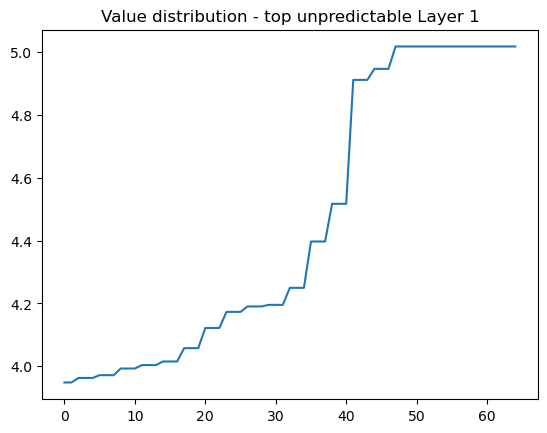

Returning 5 top unpredictable images for layer 1...


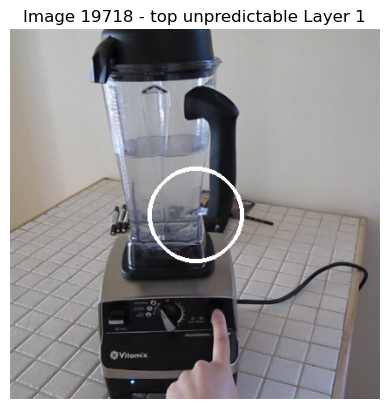

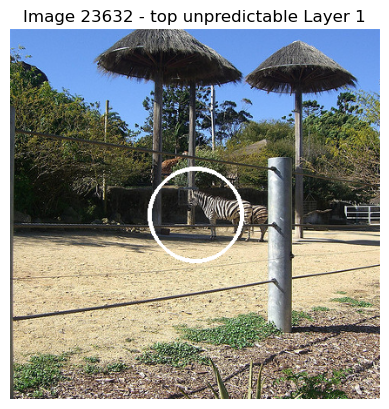

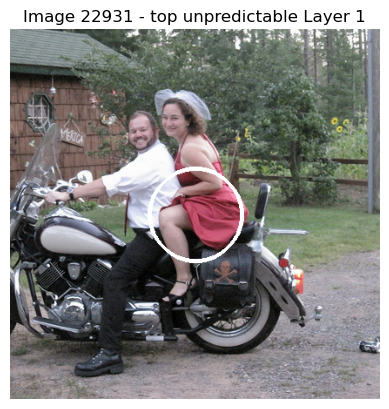

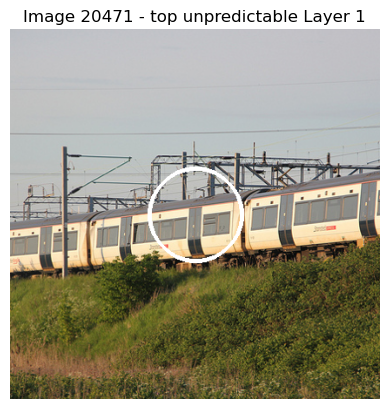

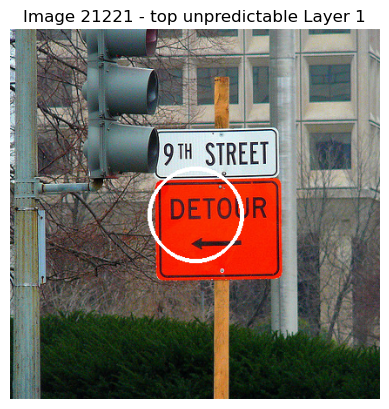

In [12]:
# This is for figuring out some of the extreme values across the axis of unpredictability
# if it doesn't make sense, just use the plot from Micha.
img_extremes = NSP.stimuli.get_img_extremes(
    X=Xpred, n=5, start_img=60, top="unpred", layer=1, add_circle=True, verbose=True
)